In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import random
import math
import time
import copy
from collections import deque, defaultdict

import matplotlib.pyplot as plt
import os
import pickle
import sys

In [2]:
import numpy as np

class GoGameAlphaZero:
    def __init__(self, board_size=5):
        self.board_size = board_size
        self.action_size = board_size * board_size
        self.row_count = board_size
        self.column_count = board_size
        self.history = []

    def get_initial_state(self):
        return np.zeros((self.board_size, self.board_size), dtype=np.int8)

    def get_next_state(self, state, action, player, record_history=True):
        row, col = divmod(action, self.board_size)
        new_state = np.copy(state)
        if new_state[row, col] != 0:
            return new_state
        new_state[row, col] = player
        opponent = -player

        for nr, nc in self.get_neighbors(row, col):
            if new_state[nr, nc] == opponent:
                group = self.get_group(new_state, nr, nc)
                if not self.has_liberty(new_state, group):
                    self.remove_group(new_state, group)

        group = self.get_group(new_state, row, col)
        if not self.has_liberty(new_state, group):
            return state

        if record_history and self.history:
            if np.array_equal(new_state, self.history[-1]):
                return state

        if record_history:
            self.history.append(np.copy(state))

        return new_state

    def get_valid_moves(self, state, player):
        valid = np.zeros(self.action_size, dtype=np.uint8)
        for i in range(self.action_size):
            row, col = divmod(i, self.board_size)
            if state[row, col] != 0:
                continue
            sim = self.get_next_state(state, i, player, record_history=False)
            if not np.array_equal(sim, state):
                valid[i] = 1
        return valid

    def get_value_and_terminated(self, state, action, player):
      flat = state[state != 0]
      if flat.size > 1 and np.all(flat == flat[0]):
          return (1 if flat[0] == 1 else -1), True

      valid_moves = self.get_valid_moves(state, player)
      if np.sum(valid_moves) == 0:
          black_stones = np.sum(state == 1)
          white_stones = np.sum(state == -1)

          if black_stones > white_stones:
              return 1, True
          elif white_stones > black_stones:
              return -1, True
          else:
              return 0, True

      return 0, False


    def get_opponent(self, player):
        return -player

    def get_opponent_value(self, value):
        return -value

    def change_perspective(self, state, player):
        return state * player

    def get_encoded_state(self, state):
        encoded = np.stack([
            (state == 1).astype(np.float32),
            (state == 0).astype(np.float32),
            (state == -1).astype(np.float32)
        ])
        return encoded

    def get_neighbors(self, row, col):
        directions = [(-1,0), (1,0), (0,-1), (0,1)]
        neighbors = []
        for dr, dc in directions:
            nr, nc = row + dr, col + dc
            if 0 <= nr < self.board_size and 0 <= nc < self.board_size:
                neighbors.append((nr, nc))
        return neighbors

    def get_group(self, board, row, col):
        visited = set()
        stack = [(row, col)]
        color = board[row][col]
        group = []
        while stack:
            r, c = stack.pop()
            if (r, c) not in visited and board[r, c] == color:
                visited.add((r, c))
                group.append((r, c))
                for nr, nc in self.get_neighbors(r, c):
                    if board[nr, nc] == color:
                        stack.append((nr, nc))
        return group

    def has_liberty(self, board, group):
        for r, c in group:
            for nr, nc in self.get_neighbors(r, c):
                if board[nr, nc] == 0:
                    return True
        return False

    def remove_group(self, board, group):
        for r, c in group:
            board[r, c] = 0

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResNet(nn.Module):
    def __init__(self, game, num_resBlocks=5, num_hidden=128):
        super().__init__()
        self.board_height = game.row_count
        self.board_width = game.column_count
        self.action_size = game.action_size

        self.startBlock = nn.Sequential(
            nn.Conv2d(3, num_hidden, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_hidden),
            nn.ReLU()
        )

        self.backBone = nn.ModuleList(
            [ResBlock(num_hidden) for _ in range(num_resBlocks)]
        )

        self.policyHead = nn.Sequential(
            nn.Conv2d(num_hidden, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * self.board_height * self.board_width, self.action_size)
        )

        self.valueHead = nn.Sequential(
            nn.Conv2d(num_hidden, 3, kernel_size=3, padding=1),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3 * self.board_height * self.board_width, 1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.startBlock(x)
        for block in self.backBone:
            x = block(x)
        policy = self.policyHead(x)
        value = self.valueHead(x)
        return policy, value


class ResBlock(nn.Module):
    def __init__(self, num_hidden):
        super().__init__()
        self.conv1 = nn.Conv2d(num_hidden, num_hidden, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_hidden)
        self.conv2 = nn.Conv2d(num_hidden, num_hidden, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_hidden)

    def forward(self, x):
        identity = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        out = F.relu(out)
        return out

[[ 0  0  0  0  0]
 [ 0  1  1  0  0]
 [ 0  0 -1  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]]
[[[0. 0. 0. 0. 0.]
  [0. 1. 1. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[1. 1. 1. 1. 1.]
  [1. 0. 0. 1. 1.]
  [1. 1. 0. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]]
0.4322153925895691 [0.03296572 0.03657424 0.03395321 0.06085989 0.04435472 0.07760715
 0.05033949 0.01246351 0.04032004 0.03280267 0.05087126 0.03375656
 0.02086587 0.01915121 0.04730298 0.02592663 0.02049106 0.02626669
 0.03416865 0.03969342 0.04378238 0.04130181 0.01873302 0.03566273
 0.11978514]


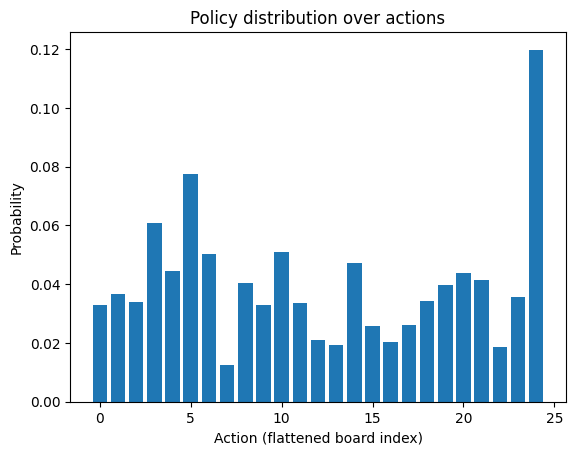

In [4]:
import matplotlib.pyplot as plt
import torch

game = GoGameAlphaZero(board_size=5)

state = game.get_initial_state()
state = game.get_next_state(state, 6, 1)
state = game.get_next_state(state, 12, -1)
state = game.get_next_state(state, 7, 1)

print(state)

encoded_state = game.get_encoded_state(state)
print(encoded_state)

tensor_state = torch.tensor(encoded_state).unsqueeze(0)

model = ResNet(game, num_resBlocks=4, num_hidden=64)

policy, value = model(tensor_state)
value = value.item()
policy = torch.softmax(policy, axis=1).squeeze(0).detach().cpu().numpy()

print(value, policy)

plt.bar(range(game.action_size), policy)
plt.title("Policy distribution over actions")
plt.xlabel("Action (flattened board index)")
plt.ylabel("Probability")
plt.show()

In [5]:
import torch
import numpy as np
import math

class Node:
    def __init__(self, game, args, state, player, parent=None, action_taken=None, prior=0):
        self.game = game
        self.args = args
        self.state = state
        self.player = player
        self.parent = parent
        self.action_taken = action_taken
        self.prior = prior

        self.children = []
        self.visit_count = 0
        self.value_sum = 0

    def is_fully_expanded(self):
        return len(self.children) > 0

    def select(self):
        best_child = None
        best_ucb = -np.inf
        for child in self.children:
            ucb = self._ucb_score(child)
            if ucb > best_ucb:
                best_ucb = ucb
                best_child = child
        return best_child

    def _ucb_score(self, child):
        if child.visit_count == 0:
            q_value = 0
        else:
            q_value = 1 - ((child.value_sum / child.visit_count) + 1) / 2
        exploration = self.args['C'] * (math.sqrt(self.visit_count) / (child.visit_count + 1))
        return q_value + exploration * child.prior

    def expand(self, policy):
        valid = self.game.get_valid_moves(self.state, self.player)
        next_player = -self.player
        for action, prob in enumerate(policy):
            if prob > 0 and valid[action]:
                child_state = self.game.get_next_state(
                    self.state.copy(), action, self.player, record_history=False
                )
                if not np.array_equal(child_state, self.state):
                    child = Node(
                        self.game,
                        self.args,
                        child_state,
                        next_player,
                        self,
                        action,
                        prob
                    )
                    self.children.append(child)
        return self.children



    def backpropagate(self, value):
        self.value_sum += value
        self.visit_count += 1
        if self.parent:
            self.parent.backpropagate(-value)


class MCTS:
    def __init__(self, game, args, model, device):
        self.game = game
        self.args = args
        self.model = model
        self.device = device
    @torch.no_grad()
    def search(self, state, player=1):
        root = Node(self.game, self.args, state, player)

        for _ in range(self.args['num_searches']):
            node = root
            path = []
            while node.is_fully_expanded():
                node = node.select()
                path.append(node)

            value, is_terminal = self.game.get_value_and_terminated(
                node.state, node.action_taken, node.player)

            if not is_terminal:
                flipped = self.game.change_perspective(node.state, node.player)
                encoded = self.game.get_encoded_state(flipped)
                tensor = torch.tensor(encoded).unsqueeze(0).to(self.device)

                policy_logits, value_tensor = self.model(tensor)
                probs = torch.softmax(policy_logits, dim=1).squeeze(0).cpu().numpy()

                valid = self.game.get_valid_moves(flipped, node.player)
                probs *= valid
                if probs.sum() > 0:
                    probs /= probs.sum()
                else:
                    probs = valid / valid.sum()

                node.expand(probs)
                value = value_tensor.item()

            node.backpropagate(value)

        visits = np.zeros(self.game.action_size)
        for child in root.children:
            visits[child.action_taken] = child.visit_count
        if visits.sum() > 0:
            return visits / visits.sum()
        return np.ones(self.game.action_size) / self.game.action_size

In [ ]:
import torch
from tqdm import trange
import numpy as np
import os


class AlphaZero:
    def __init__(self, model, optimizer, game, args):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)
        self.optimizer = optimizer
        self.game = game
        self.args = args
        self.mcts = MCTS(game, args, self.model, self.device)
        self.best_model_state = self.model.state_dict()
        self.best_win_rate = 0

    def selfPlay(self):
        memory = []
        player = 1
        state = self.game.get_initial_state()
        temperature = self.args.get('temperature', 1.0)

        while True:
            neutral_state = self.game.change_perspective(state, player)
            action_probs = self.mcts.search(neutral_state, player)

            if np.sum(action_probs) == 0 or np.any(np.isnan(action_probs)):
                action_probs = np.ones(self.game.action_size) / self.game.action_size

            if temperature != 1.0:
                action_probs = np.power(action_probs, 1/temperature)
                action_probs /= np.sum(action_probs)

            memory.append((neutral_state, action_probs, player))
            action = np.random.choice(self.game.action_size, p=action_probs)
            state = self.game.get_next_state(state, action, player)

            value, is_terminal = self.game.get_value_and_terminated(state, action, player)

            if is_terminal:
                returnMemory = []
                for hist_state, hist_probs, hist_player in memory:
                    hist_outcome = value if hist_player == player else self.game.get_opponent_value(value)
                    encoded = self.game.get_encoded_state(hist_state)
                    encoded_tensor = torch.tensor(encoded, dtype=torch.float32).to(self.device)
                    returnMemory.append((
                        encoded_tensor.cpu().numpy(),
                        hist_probs,
                        hist_outcome
                    ))
                return returnMemory

            player = self.game.get_opponent(player)

    def train(self, memory):
        batch_size = self.args.get('batch_size', 128)
        np.random.shuffle(memory)

        for i in range(0, len(memory), batch_size):
            batch = memory[i:i+batch_size]
            state_batch, policy_batch, value_batch = zip(*batch)

            state_batch = torch.tensor(np.array(state_batch), dtype=torch.float32).to(self.device)
            policy_batch = torch.tensor(np.array(policy_batch), dtype=torch.float32).to(self.device)
            value_batch = torch.tensor(np.array(value_batch), dtype=torch.float32).view(-1,1).to(self.device)

            pred_policy, pred_value = self.model(state_batch)

            policy_loss = -(policy_batch * torch.log_softmax(pred_policy, dim=1)).sum(dim=1).mean()
            value_loss = torch.mean((value_batch - pred_value)**2)

            loss = policy_loss + value_loss

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

    def evaluate_model(self, iterations=10):
        wins = 0
        for _ in range(iterations):
            winner = self.play_game(self.model, self.best_model_state)
            if winner == 1:
                wins += 1
        return wins / iterations

    def play_game(self, new_model, old_model_state):
        temp_model = ResNet(self.game,
                            num_resBlocks=self.args['num_resBlocks'],
                            num_hidden=self.args['num_hidden']).to(self.device)
        temp_model.load_state_dict(old_model_state)
        new_mcts = MCTS(self.game, self.args, new_model, self.device)
        old_mcts = MCTS(self.game, self.args, temp_model, self.device)

        state = self.game.get_initial_state()
        player = 1

        while True:
            neutral_state = self.game.change_perspective(state, player)
            mcts = new_mcts if player == 1 else old_mcts
            action_probs = mcts.search(neutral_state, player)
            action = np.argmax(action_probs)

            state = self.game.get_next_state(state, action, player)
            value, is_terminal = self.game.get_value_and_terminated(state, action, player)

            if is_terminal:
                return player if value == 1 else self.game.get_opponent(player)

            player = self.game.get_opponent(player)

    def learn(self):
        for iteration in range(self.args['num_iterations']):
            memory = []
            self.model.eval()

            for _ in trange(self.args['num_selfPlay_iterations'],
                            desc=f"Self-play Iteration {iteration+1}"):
                memory += self.selfPlay()

            self.model.train()
            for _ in trange(self.args['num_epochs'],
                            desc=f"Training Epochs {iteration+1}"):
                self.train(memory)

            win_rate = self.evaluate_model(iterations=self.args.get('evaluation_games', 10))
            print(f"Evaluation win rate at iteration {iteration}: {win_rate:.2f}")

            if win_rate > self.best_win_rate:
                self.best_win_rate = win_rate
                self.best_model_state = self.model.state_dict()
                torch.save(self.best_model_state, "best_model.pt")
                print(f"New best model saved with win rate {win_rate:.2f}")

            torch.save(self.model.state_dict(), f"model_{iteration}.pt")
            torch.save(self.optimizer.state_dict(), f"optimizer_{iteration}.pt")

if __name__ == "__main__":
    game = GoGameAlphaZero()
    model = ResNet(game, num_resBlocks=4, num_hidden=64)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    args = {
        'C': 2,
        'num_searches': 100,
        'num_iterations': 50,
        'num_selfPlay_iterations': 50,
        'num_epochs': 8,
        'batch_size': 128,
        'evaluation_games': 10,
        'temperature': 1.0,
        'num_resBlocks': 4,
        'num_hidden': 64
    }

    alphaZero = AlphaZero(model, optimizer, game, args)
    alphaZero.learn()


In [6]:
import torch
import numpy as np

game = GoGameAlphaZero()
player = 1

def print_board(state):
    print("   ", end='')
    for col in range(1, game.column_count + 1):
        print(f" {col}  ", end='')
    print("\n  +" + "---+" * game.column_count)
    for i, row in enumerate(state):
        print(f"{i+1} |", end='')
        for cell in row:
            if cell == 1:
                print(" B |", end='')
            elif cell == -1:
                print(" W |", end='')
            else:
                print("   |", end='')
        print("\n  +" + "---+" * game.column_count)

args = {'C': 2, 'num_searches': 1000}
model = ResNet(game, num_resBlocks=4, num_hidden=64)
model.load_state_dict(torch.load("model_19.pt", map_location=torch.device("cpu")))
model.eval()
mcts = MCTS(game, args, model, device=torch.device("cpu"))

state = game.get_initial_state()

while True:
    print_board(state)

    valid_moves = game.get_valid_moves(state, player)
    valid_idxs = [i for i, v in enumerate(valid_moves) if v]

    if player == 1:
        if not valid_idxs:
            value, _ = game.get_value_and_terminated(state, None, player)
            break

        try:
            r = int(input("Enter row (1-5): ")) - 1
            c = int(input("Enter col (1-5): ")) - 1
        except ValueError:
            print("Invalid input. Use numbers 1–5.")
            continue

        if not (0 <= r < game.row_count and 0 <= c < game.column_count):
            print("Out of bounds. Try again.")
            continue

        action = r * game.column_count + c
        if action not in valid_idxs:
            print("Illegal move. Try again.")
            continue

        new_state = game.get_next_state(state, action, player)
        if np.array_equal(new_state, state):
            print("Invalid move (Ko or suicide). Try again.")
            continue

        state = new_state
        player = game.get_opponent(player)

    else:
        if not valid_moves.any():
            value, _ = game.get_value_and_terminated(state, None, player)
            break

        print("AI is thinking...")
        probs = mcts.search(state, player)
        valid = game.get_valid_moves(state, player)
        probs *= valid
        if probs.sum() == 0:
            probs = valid / valid.sum()
        else:
            probs /= probs.sum()

        action = int(np.argmax(probs))
        if not valid[action]:
            valid_probs = probs * valid
            if valid_probs.sum() > 0:
                action = int(np.argmax(valid_probs))
            else:
                action = np.random.choice(np.where(valid)[0])

        r, c = divmod(action, game.column_count)
        print(f"AI plays: ({r+1}, {c+1})")

        state = game.get_next_state(state, action, player)
        player = game.get_opponent(player)

    value, is_term = game.get_value_and_terminated(state, action, player)
    if is_term:
        break

print_board(state)
if value == 1:
    print("Black wins!")
elif value == -1:
    print("White wins!")
else:
    print("Draw!")

    1   2   3   4   5  
  +---+---+---+---+---+
1 |   |   |   |   |   |
  +---+---+---+---+---+
2 |   |   |   |   |   |
  +---+---+---+---+---+
3 |   |   |   |   |   |
  +---+---+---+---+---+
4 |   |   |   |   |   |
  +---+---+---+---+---+
5 |   |   |   |   |   |
  +---+---+---+---+---+
Enter row (1-5): 1
Enter col (1-5): 1
    1   2   3   4   5  
  +---+---+---+---+---+
1 | B |   |   |   |   |
  +---+---+---+---+---+
2 |   |   |   |   |   |
  +---+---+---+---+---+
3 |   |   |   |   |   |
  +---+---+---+---+---+
4 |   |   |   |   |   |
  +---+---+---+---+---+
5 |   |   |   |   |   |
  +---+---+---+---+---+
AI is thinking...


<ipython-input-5-a064cafbed86>:103: RuntimeWarning: invalid value encountered in divide
  probs = valid / valid.sum()


AI plays: (4, 4)
    1   2   3   4   5  
  +---+---+---+---+---+
1 | B |   |   |   |   |
  +---+---+---+---+---+
2 |   |   |   |   |   |
  +---+---+---+---+---+
3 |   |   |   |   |   |
  +---+---+---+---+---+
4 |   |   |   | W |   |
  +---+---+---+---+---+
5 |   |   |   |   |   |
  +---+---+---+---+---+
Enter row (1-5): 2
Enter col (1-5): 3
    1   2   3   4   5  
  +---+---+---+---+---+
1 | B |   |   |   |   |
  +---+---+---+---+---+
2 |   |   | B |   |   |
  +---+---+---+---+---+
3 |   |   |   |   |   |
  +---+---+---+---+---+
4 |   |   |   | W |   |
  +---+---+---+---+---+
5 |   |   |   |   |   |
  +---+---+---+---+---+
AI is thinking...
AI plays: (3, 4)
    1   2   3   4   5  
  +---+---+---+---+---+
1 | B |   |   |   |   |
  +---+---+---+---+---+
2 |   |   | B |   |   |
  +---+---+---+---+---+
3 |   |   |   | W |   |
  +---+---+---+---+---+
4 |   |   |   | W |   |
  +---+---+---+---+---+
5 |   |   |   |   |   |
  +---+---+---+---+---+
Enter row (1-5): 3
Enter col (1-5): 3
    1   